# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [54]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [55]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [61]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [44]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [62]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradients are different at (0, 0). Analytic: 0.20603, Numeric: 0.41206
Gradients are different at (0, 0). Analytic: 0.19516, Numeric: 4.68376


AssertionError: 

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [75]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradients are different at (0, 0). Analytic: -0.11246, Numeric: -0.44983


False

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [76]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [86]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 0, loss: 3440163.496080



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.64it/s]

Epoch 1, loss: 2724307.990832



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.00it/s]

Epoch 2, loss: 4488211.481789



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.34it/s]

Epoch 3, loss: 2789165.300606



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.84it/s]

Epoch 4, loss: 2843969.876817



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.29it/s]

Epoch 5, loss: 4176275.243826



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 6, loss: 3280677.798007



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.47it/s]

Epoch 7, loss: 3160995.605070



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 8, loss: 3584488.465966



100%|████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.96it/s]

Epoch 9, loss: 3326912.841512


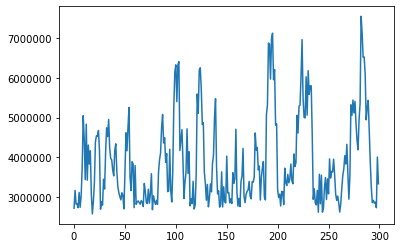

In [87]:
# let's look at the loss history!
plt.plot(loss_history)

In [91]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.40it/s]

Accuracy:  0.09



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.68it/s]

Epoch 0, loss: 3166470.224987



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.67it/s]

Epoch 1, loss: 2952489.480832



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.41it/s]

Epoch 2, loss: 3269938.734097



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 3, loss: 3918160.751927



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.64it/s]

Epoch 4, loss: 2780254.864109



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 5, loss: 3105984.568027



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 6, loss: 3372594.380183



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.45it/s]

Epoch 7, loss: 3719077.858952



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.43it/s]

Epoch 8, loss: 3205876.779294



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 9, loss: 2877887.315898



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 10, loss: 2881202.306063



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 11, loss: 3379087.129528



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 12, loss: 3050328.861782



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.91it/s]

Epoch 13, loss: 3857262.173598



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.01it/s]

Epoch 14, loss: 3352469.965473



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 15, loss: 3827117.534137



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.88it/s]

Epoch 16, loss: 2658030.912434



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 17, loss: 2871577.882510



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.47it/s]

Epoch 18, loss: 3437411.657104



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 19, loss: 3501344.125191



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 20, loss: 3543305.356802



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.74it/s]

Epoch 21, loss: 2927062.955932



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.90it/s]

Epoch 22, loss: 2666750.389256



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 23, loss: 2895242.334757



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.66it/s]

Epoch 24, loss: 2899987.869783



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 25, loss: 2826690.515644



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.90it/s]

Epoch 26, loss: 3888089.925734



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 27, loss: 3573773.878182



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.29it/s]

Epoch 28, loss: 3392771.144879



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 29, loss: 4106127.288384



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 30, loss: 3338352.358211



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.40it/s]

Epoch 31, loss: 2862880.148566



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 32, loss: 2635618.563888



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 33, loss: 4567155.018867



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 34, loss: 3341868.137451



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 35, loss: 4161184.677293



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 36, loss: 2733601.512614



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.87it/s]

Epoch 37, loss: 2764736.786068



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 38, loss: 2786337.675256



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 39, loss: 3563308.917741



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.30it/s]

Epoch 40, loss: 2808581.432315



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 41, loss: 3513747.988578



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 42, loss: 3120072.644256



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.29it/s]

Epoch 43, loss: 3363495.955084



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.25it/s]

Epoch 44, loss: 3349607.916689



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 45, loss: 3563655.939211



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.57it/s]

Epoch 46, loss: 2918243.964059



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 47, loss: 3114149.532356



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 48, loss: 3036433.210916



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.90it/s]

Epoch 49, loss: 3904735.395839



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 77.68it/s]

Epoch 50, loss: 3631978.609333



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 51, loss: 2924424.528648



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 52, loss: 4588816.157093



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 53, loss: 5082009.293112



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 54, loss: 3244602.216171



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 55, loss: 3788181.238604



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 56, loss: 3125079.077402



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.56it/s]

Epoch 57, loss: 3553221.007077



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.43it/s]

Epoch 58, loss: 3582295.028059



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.41it/s]

Epoch 59, loss: 3381785.979285



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 60, loss: 2801411.993061



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 61, loss: 2939010.169594



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 62, loss: 2945413.926817



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 71.51it/s]

Epoch 63, loss: 3281194.374698



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 64, loss: 2780584.481783



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.66it/s]

Epoch 65, loss: 3964673.919122



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.43it/s]

Epoch 66, loss: 3760487.041410



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 67, loss: 4285219.680027



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 68, loss: 4055772.232936



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 69, loss: 3621957.809381



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 70, loss: 3795990.385638



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.70it/s]

Epoch 71, loss: 3116601.174830



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.92it/s]

Epoch 72, loss: 3482542.735132



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 73, loss: 2932961.764442



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.93it/s]

Epoch 74, loss: 2857377.263180



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 75, loss: 3327727.885710



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.47it/s]

Epoch 76, loss: 2829980.846910



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 77, loss: 2713983.384321



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 78, loss: 3106725.279977



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 79, loss: 3101325.387558



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 80, loss: 2937968.529035



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.45it/s]

Epoch 81, loss: 3004819.292867



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 82, loss: 4500643.411736



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.15it/s]

Epoch 83, loss: 3088402.905078



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 77.71it/s]

Epoch 84, loss: 3024822.304228



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 85, loss: 3289436.583800



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 86, loss: 2759389.838100



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 87, loss: 2817338.304075



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 88, loss: 2922788.124456



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 89, loss: 3812853.750656



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.04it/s]

Epoch 90, loss: 3769097.297958



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 86.32it/s]

Epoch 91, loss: 2686354.302993



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 92, loss: 2893692.437760



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 93, loss: 2689430.174764



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.30it/s]

Epoch 94, loss: 2922020.880316



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.55it/s]

Epoch 95, loss: 3773493.026060



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 96, loss: 2850141.973297



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.25it/s]

Epoch 97, loss: 2951424.086979



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 98, loss: 3079396.492038



100%|██████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 99, loss: 3955630.740653
Accuracy after training for 100 epochs:  0.049


### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [94]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
best_val_accuracy = 0
for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        loss_history = classifier.fit(train_X, train_y, epochs=100, learning_rate=learning_rate, 
                                      batch_size=300, reg=reg_strength)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if accuracy >= best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier
            best_loss_history = loss_history
            best_param = (learning_rate, reg_strength)

print('best validation accuracy achieved: %f' % best_val_accuracy)

 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 0, loss: 2750315.895298



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 1, loss: 3195511.330037



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.87it/s]

Epoch 2, loss: 5287591.017857



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 3, loss: 5561859.604337



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 4, loss: 5674708.930875



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.28it/s]

Epoch 5, loss: 6313494.951152



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.14it/s]

Epoch 6, loss: 6654522.410936



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.03it/s]

Epoch 7, loss: 8257641.772985



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.25it/s]

Epoch 8, loss: 7223524.168502



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.87it/s]

Epoch 9, loss: 9951046.449833



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 102.01it/s]

Epoch 10, loss: 10984295.754425



 23%|████████████▎                                        | 7/30 [00:00<00:00, 62.56it/s]

Epoch 11, loss: 11519608.302957



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.35it/s]

Epoch 12, loss: 10939967.925792



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 13, loss: 11128122.319095



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 14, loss: 12975530.404184



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.94it/s]

Epoch 15, loss: 14049330.991026



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.16it/s]

Epoch 16, loss: 12222589.892534



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 17, loss: 12330403.773309



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 18, loss: 13733264.143805



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.45it/s]

Epoch 19, loss: 15609960.491992



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.25it/s]

Epoch 20, loss: 15494517.136896



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.34it/s]

Epoch 21, loss: 18026510.891466



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 71.52it/s]

Epoch 22, loss: 18960484.756298



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 23, loss: 17672476.472079



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.67it/s]

Epoch 24, loss: 19785488.220922



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.86it/s]

Epoch 25, loss: 17537519.423694



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]


Epoch 26, loss: 20010329.431624


 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 27, loss: 21580323.951588



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 28, loss: 21892318.889172



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 29, loss: 20137211.327900



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.49it/s]

Epoch 30, loss: 25172409.368581



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.93it/s]

Epoch 31, loss: 26421555.077296



 43%|██████████████████████                             | 13/30 [00:00<00:00, 125.17it/s]

Epoch 32, loss: 29614602.222579



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 33, loss: 24540187.484935



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 34, loss: 23239897.500563



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 35, loss: 23763771.653565



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 36, loss: 28422419.989083



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.50it/s]

Epoch 37, loss: 27859713.813174



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.49it/s]

Epoch 38, loss: 28307834.664380



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.50it/s]

Epoch 39, loss: 33997772.395030



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 40, loss: 29874763.925964



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.66it/s]

Epoch 41, loss: 29206358.324833



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.49it/s]

Epoch 42, loss: 28979713.388363



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 43, loss: 33938579.521851



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 44, loss: 31395086.033111



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.50it/s]

Epoch 45, loss: 31853189.076399



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.50it/s]

Epoch 46, loss: 35312994.389810



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.50it/s]

Epoch 47, loss: 36939331.329076



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 48, loss: 33486862.509286



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 49, loss: 37041148.608771



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.23it/s]

Epoch 50, loss: 33841105.548347



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.24it/s]

Epoch 51, loss: 34953794.520655



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 52, loss: 32865497.350445



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 53, loss: 37969037.939756



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 54, loss: 41562139.582391



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 55, loss: 37667843.140897



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 56, loss: 40397497.982615



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 57, loss: 48800183.145905



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.70it/s]

Epoch 58, loss: 41387796.915395



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 59, loss: 38339820.885294



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.95it/s]

Epoch 60, loss: 44687604.036075



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.49it/s]

Epoch 61, loss: 37395241.937818



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 62, loss: 42969534.964617



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 63, loss: 44879889.680699



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.03it/s]

Epoch 64, loss: 40529998.346820



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.16it/s]

Epoch 65, loss: 49427733.451622



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 77.69it/s]

Epoch 66, loss: 45804639.712756



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.44it/s]

Epoch 67, loss: 46725069.124672



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.25it/s]

Epoch 68, loss: 55908308.443480



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.23it/s]

Epoch 69, loss: 44733862.634807



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 70, loss: 40826929.183646



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 71, loss: 53101815.627645



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.29it/s]

Epoch 72, loss: 48870526.257198



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 73, loss: 53035672.264870



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 74, loss: 48323007.464595



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 75, loss: 47155627.701265



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 76, loss: 57794374.961215



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 69.03it/s]

Epoch 77, loss: 66579174.077639



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 78, loss: 53137669.781367



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.69it/s]

Epoch 79, loss: 60497306.310636



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 80, loss: 60438757.619744



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.43it/s]

Epoch 81, loss: 52208285.325193



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.47it/s]

Epoch 82, loss: 58580699.038259



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 83, loss: 66824937.386758



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.50it/s]

Epoch 84, loss: 57358434.421563



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 85, loss: 57345372.730816



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 86, loss: 68494938.325581



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.03it/s]

Epoch 87, loss: 61795752.997216



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.27it/s]

Epoch 88, loss: 59785107.065242



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.45it/s]

Epoch 89, loss: 65548171.043422



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 90, loss: 54110684.032686



 23%|████████████▎                                        | 7/30 [00:00<00:00, 67.40it/s]

Epoch 91, loss: 60782500.573258



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.92it/s]

Epoch 92, loss: 72682898.731944



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 93, loss: 60214627.277685



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 94, loss: 66210956.078271



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.93it/s]

Epoch 95, loss: 64506388.213416



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.03it/s]

Epoch 96, loss: 64047449.358233



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 97, loss: 73993821.107275



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.34it/s]

Epoch 98, loss: 61417647.710817



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.42it/s]

Epoch 99, loss: 65597643.486522



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.96it/s]

Epoch 0, loss: 3025043.894638



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 1, loss: 3451176.235914



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.92it/s]

Epoch 2, loss: 3462253.924048



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 3, loss: 4494456.789070



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 4, loss: 5998350.543101



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 5, loss: 5809056.980288



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 6, loss: 6975804.479480



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 7, loss: 6977268.142983



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.28it/s]

Epoch 8, loss: 7280612.107947



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 9, loss: 8545337.471352



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 10, loss: 10823589.213701



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.28it/s]

Epoch 11, loss: 9340562.967134



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 12, loss: 11081444.974021



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.66it/s]

Epoch 13, loss: 11791072.404686



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 14, loss: 8798506.310435



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 15, loss: 11417526.649413



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.66it/s]

Epoch 16, loss: 13278890.413565



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 17, loss: 13225132.762865



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.63it/s]

Epoch 18, loss: 14325613.827957



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 19, loss: 18065447.513903



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.88it/s]

Epoch 20, loss: 15368348.287112



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.28it/s]

Epoch 21, loss: 19382567.346624



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 77.70it/s]

Epoch 22, loss: 16279498.635215



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 23, loss: 22471544.610684



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 24, loss: 18786612.962172



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.44it/s]

Epoch 25, loss: 15563532.470753



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 26, loss: 20514711.127006



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 27, loss: 21940135.191391



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 28, loss: 20631014.785191



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 76.98it/s]

Epoch 29, loss: 23472690.380575



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 30, loss: 21273161.319078



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 31, loss: 22436332.292605



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 32, loss: 20659147.827580



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 33, loss: 21812970.705631



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 34, loss: 24439837.848902



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.95it/s]

Epoch 35, loss: 24709984.141798



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]


Epoch 36, loss: 24839981.628631


 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 37, loss: 24829434.440049



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 38, loss: 27554659.507719



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 39, loss: 27187669.978319



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.03it/s]

Epoch 40, loss: 34113612.521723



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 77.69it/s]

Epoch 41, loss: 34414788.481738



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 77.68it/s]

Epoch 42, loss: 33508012.573975



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.40it/s]

Epoch 43, loss: 31754815.067468



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.93it/s]

Epoch 44, loss: 30750153.246910



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 45, loss: 32343149.354037



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.23it/s]

Epoch 46, loss: 32760311.348945



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.28it/s]

Epoch 47, loss: 40669530.346646



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 48, loss: 32292036.042662



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 49, loss: 30741748.647752



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.27it/s]

Epoch 50, loss: 36583976.124690



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 51, loss: 33233808.215950



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.29it/s]

Epoch 52, loss: 38778263.940535



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 53, loss: 45239952.890982



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 54, loss: 36480047.605311



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.88it/s]

Epoch 55, loss: 41003300.610525



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.29it/s]

Epoch 56, loss: 39879714.866512



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.48it/s]

Epoch 57, loss: 43132625.912021



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 58, loss: 41460378.319071



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.49it/s]

Epoch 59, loss: 41669544.352743



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 60, loss: 43192485.778559



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 61, loss: 39032125.079564



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.25it/s]

Epoch 62, loss: 42501954.180293



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 63, loss: 45043100.411639



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 64, loss: 48105561.920916



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.34it/s]

Epoch 65, loss: 48108474.511136



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 66, loss: 47717951.220958



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 67, loss: 53153140.035587



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 68, loss: 38097777.452399



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.73it/s]

Epoch 69, loss: 55859258.373569



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.29it/s]

Epoch 70, loss: 43780163.160101



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]


Epoch 71, loss: 51041185.280735


 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 72, loss: 44725451.614954



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 73, loss: 52034207.263792



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.52it/s]

Epoch 74, loss: 51567958.380766



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 75, loss: 51421956.667831



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 76, loss: 49634355.874313



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.92it/s]

Epoch 77, loss: 58314274.175510



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 78, loss: 56225836.021478



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.55it/s]

Epoch 79, loss: 58202370.629543



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.51it/s]

Epoch 80, loss: 52496096.580151



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.50it/s]

Epoch 81, loss: 50529973.824771



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.50it/s]

Epoch 82, loss: 56841321.852312



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 83, loss: 55576851.993868



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.88it/s]

Epoch 84, loss: 53057878.995247



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 85, loss: 70498862.033611



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.30it/s]

Epoch 86, loss: 59563567.992551



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 87, loss: 55951390.368352



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.27it/s]

Epoch 88, loss: 58438839.401989



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 89, loss: 61952957.990469



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 90, loss: 56988695.316342



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 91, loss: 59289213.634441



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 92, loss: 68630793.556272



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 93, loss: 58297726.913139



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 94, loss: 62386391.222594



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 95, loss: 61044838.958658



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 96, loss: 65120159.614355



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 97, loss: 78788866.379080



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.86it/s]

Epoch 98, loss: 61201710.542255



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 108.68it/s]

Epoch 99, loss: 73581144.520336



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.24it/s]

Epoch 0, loss: 2779913.646147



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 1, loss: 3296582.694710



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.28it/s]

Epoch 2, loss: 3299835.716755



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.27it/s]

Epoch 3, loss: 4187506.409448



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]


Epoch 4, loss: 6765216.439752


 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 5, loss: 6269068.901564



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.29it/s]

Epoch 6, loss: 7082677.646391



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.50it/s]

Epoch 7, loss: 6597606.318758



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 8, loss: 7563717.098234



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 9, loss: 9549594.713770



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.52it/s]

Epoch 10, loss: 10909574.894649



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 11, loss: 8121804.116418



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 12, loss: 10807902.327755



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.27it/s]

Epoch 13, loss: 9888174.890203



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.66it/s]

Epoch 14, loss: 10108727.965434



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.03it/s]

Epoch 15, loss: 11682653.381200



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 77.69it/s]

Epoch 16, loss: 11520079.080133



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 17, loss: 10747252.657795



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 77.68it/s]

Epoch 18, loss: 16364753.641612



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.43it/s]

Epoch 19, loss: 12454821.005696



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.43it/s]

Epoch 20, loss: 13502819.815452



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.00it/s]

Epoch 21, loss: 16396177.865447



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 22, loss: 17017988.481973



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 23, loss: 17171835.057529



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 24, loss: 20417752.803208



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 25, loss: 16769991.176104



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 26, loss: 18482680.750193



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 27, loss: 22138143.979314



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.25it/s]

Epoch 28, loss: 21257545.146671



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 29, loss: 21073788.699411



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 102.00it/s]

Epoch 30, loss: 22694099.868182



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 31, loss: 24049685.583388



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 32, loss: 22898282.144008



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 33, loss: 23752567.443285



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 34, loss: 23441919.292731



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 35, loss: 26691549.098891



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 109.41it/s]

Epoch 36, loss: 24220831.869137



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 37, loss: 22661888.191616



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 38, loss: 26564440.105437



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.90it/s]

Epoch 39, loss: 26824151.150068



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.93it/s]

Epoch 40, loss: 33200516.010612



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 41, loss: 30752236.639453



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.96it/s]

Epoch 42, loss: 31128692.135024



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.50it/s]

Epoch 43, loss: 32978471.376690



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.90it/s]

Epoch 44, loss: 29420878.887951



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.85it/s]

Epoch 45, loss: 29864387.847673



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 46, loss: 30673371.331258



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.87it/s]

Epoch 47, loss: 34312347.479132



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 48, loss: 33667009.483371



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.22it/s]

Epoch 49, loss: 33744447.181043



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.28it/s]

Epoch 50, loss: 33721905.157697



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 51, loss: 40265376.070723



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.27it/s]

Epoch 52, loss: 37580455.314068



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 53, loss: 37482037.661469



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 54, loss: 38937533.298282



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 55, loss: 42404894.367106



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 56, loss: 40903184.684072



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.50it/s]

Epoch 57, loss: 42768105.888076



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 58, loss: 41436405.823966



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 59, loss: 37493294.356973



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 60, loss: 42498984.463112



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 61, loss: 43596386.321462



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.40it/s]

Epoch 62, loss: 35419973.759468



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 63, loss: 43965928.887181



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.69it/s]

Epoch 64, loss: 42651615.075192



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 65, loss: 41721826.241564



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.69it/s]

Epoch 66, loss: 50490677.537247



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 67, loss: 51578834.204627



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 68, loss: 46890112.005206



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.24it/s]

Epoch 69, loss: 38691296.679698



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.88it/s]

Epoch 70, loss: 42104777.973324



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.88it/s]

Epoch 71, loss: 54457799.975833



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 72, loss: 46342683.296492



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.94it/s]

Epoch 73, loss: 53066511.760597



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 74, loss: 49826133.620769



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 75, loss: 53821555.967826



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.96it/s]

Epoch 76, loss: 53910180.262309



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.23it/s]

Epoch 77, loss: 55949430.950141



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.28it/s]

Epoch 78, loss: 59326717.165276



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 79, loss: 55818303.015821



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 80, loss: 53242199.254175



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.27it/s]

Epoch 81, loss: 47671797.317715



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.26it/s]

Epoch 82, loss: 59008619.460478



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 83, loss: 59697724.428286



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 84, loss: 63373193.799742



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.94it/s]

Epoch 85, loss: 57074189.390358



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.23it/s]

Epoch 86, loss: 62653048.905335



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.85it/s]

Epoch 87, loss: 65036259.620200



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.25it/s]

Epoch 88, loss: 53094924.792314



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.88it/s]

Epoch 89, loss: 53785686.332420



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.93it/s]

Epoch 90, loss: 62214949.376226



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 91, loss: 60366429.323921



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.88it/s]

Epoch 92, loss: 62895163.468483



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 93, loss: 67320804.590993



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 94, loss: 59656112.321856



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 95, loss: 65151649.879398



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 96, loss: 59675896.886487



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.30it/s]

Epoch 97, loss: 65515934.864859



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.88it/s]

Epoch 98, loss: 70706276.576696



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 99, loss: 60361365.361121



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.34it/s]

Epoch 0, loss: 2761378.966782



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]


Epoch 1, loss: 2700300.685092


 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.34it/s]

Epoch 2, loss: 2743748.076899



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 109.62it/s]


Epoch 3, loss: 2608593.767641


 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 4, loss: 2761523.375067



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 5, loss: 3022965.202138



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 6, loss: 2738574.123718



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 7, loss: 2822711.175534



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 8, loss: 2942289.068435



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 9, loss: 2872369.671942



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 10, loss: 3000749.247167



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 11, loss: 2863003.542822



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 12, loss: 3112632.209966



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 13, loss: 2892319.325386



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 14, loss: 3413716.075626



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 15, loss: 3141819.291408



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.94it/s]

Epoch 16, loss: 3199477.395577



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 17, loss: 3050770.251832



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 18, loss: 2917061.477868



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 19, loss: 3270480.469571



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 20, loss: 3096613.869727



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 21, loss: 3284386.088778



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 22, loss: 3374207.285205



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 23, loss: 3652984.675442



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 24, loss: 3363504.564713



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 25, loss: 3914271.251892



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.96it/s]

Epoch 26, loss: 3714760.057017



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 27, loss: 3686609.710609



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.89it/s]


Epoch 28, loss: 3782287.485279


 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.43it/s]

Epoch 29, loss: 3790178.578874



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 30, loss: 4328233.090526



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 31, loss: 4110379.263685



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 32, loss: 4167740.916318



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 33, loss: 3975315.689949



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.92it/s]

Epoch 34, loss: 3988786.499996



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 35, loss: 3992256.621435



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 36, loss: 4223154.287998



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.27it/s]

Epoch 37, loss: 4594095.719133



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 38, loss: 4301327.614919



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 39, loss: 5220947.599031



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 40, loss: 5102004.415803



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 41, loss: 4602888.837813



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 42, loss: 4456446.482350



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.52it/s]

Epoch 43, loss: 4642301.299058



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 44, loss: 4921952.972029



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.35it/s]

Epoch 45, loss: 4906733.111829



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.48it/s]

Epoch 46, loss: 4872120.107147



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 47, loss: 5224642.627878



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.03it/s]

Epoch 48, loss: 4853190.303260



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 76.99it/s]

Epoch 49, loss: 4731909.386077



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 50, loss: 4864362.284840



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 76.99it/s]

Epoch 51, loss: 5333286.383640



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 52, loss: 4635271.194555



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 53, loss: 5038566.091372



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 54, loss: 5435299.286172



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.47it/s]

Epoch 55, loss: 5801345.364561



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 56, loss: 5721358.483153



 23%|████████████▎                                        | 7/30 [00:00<00:00, 67.39it/s]

Epoch 57, loss: 5342972.741152



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.03it/s]

Epoch 58, loss: 5327774.271694



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 59, loss: 5697041.879778



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.16it/s]

Epoch 60, loss: 6457249.051779



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 69.06it/s]

Epoch 61, loss: 5873509.002712



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 62, loss: 6668543.965720



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 63, loss: 5228971.373068



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.49it/s]

Epoch 64, loss: 6448165.323690



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.94it/s]

Epoch 65, loss: 5949724.344456



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.48it/s]

Epoch 66, loss: 6111852.418867



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.49it/s]

Epoch 67, loss: 6550309.450699



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.49it/s]

Epoch 68, loss: 6514349.577670



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.95it/s]

Epoch 69, loss: 6249429.996134



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 70, loss: 6881008.166266



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.48it/s]


Epoch 71, loss: 6609794.706029


 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 72, loss: 7079338.221780



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 73, loss: 5501464.252785



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.58it/s]

Epoch 74, loss: 5782471.138024



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 75, loss: 6254819.752140



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.93it/s]

Epoch 76, loss: 6724791.097751



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 77, loss: 6376021.063410



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.34it/s]

Epoch 78, loss: 7917447.586961



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 79, loss: 6641934.202767



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 80, loss: 6362636.277618



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.86it/s]

Epoch 81, loss: 6835326.073746



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.22it/s]

Epoch 82, loss: 7762283.834466



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 83, loss: 7796223.572608



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 84, loss: 6995776.273036



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.22it/s]

Epoch 85, loss: 6727261.966268



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 86, loss: 6590073.759541



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.95it/s]

Epoch 87, loss: 7739390.041726



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 88, loss: 7510744.553594



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 89, loss: 8267925.630066



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 90, loss: 7373514.563168



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.48it/s]

Epoch 91, loss: 8176022.771620



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.48it/s]

Epoch 92, loss: 8331253.699276



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.25it/s]

Epoch 93, loss: 6453410.454604



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 94, loss: 8038589.946447



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.87it/s]

Epoch 95, loss: 8314911.643419



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.22it/s]

Epoch 96, loss: 7964156.175135



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.86it/s]

Epoch 97, loss: 7873086.787570



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.25it/s]

Epoch 98, loss: 7855737.599832



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.93it/s]

Epoch 99, loss: 8778898.782458



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 0, loss: 2854663.973024



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.47it/s]

Epoch 1, loss: 2676229.538370



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.86it/s]

Epoch 2, loss: 2773934.714001



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 3, loss: 2906771.965447



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 4, loss: 3021719.510519



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 5, loss: 2862821.132413



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.34it/s]

Epoch 6, loss: 2880697.230986



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 7, loss: 2917019.756781



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.40it/s]

Epoch 8, loss: 2878464.762298



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.64it/s]

Epoch 9, loss: 3078326.737755



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 10, loss: 2993988.708813



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.94it/s]

Epoch 11, loss: 3142161.108785



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.21it/s]

Epoch 12, loss: 3003740.094248



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.49it/s]


Epoch 13, loss: 3055475.587968


 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.48it/s]

Epoch 14, loss: 3214598.971038



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.86it/s]

Epoch 15, loss: 3307865.062500



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 16, loss: 3253414.749778



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.22it/s]

Epoch 17, loss: 3452656.639856



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 18, loss: 3567987.662710



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 19, loss: 3156758.136646



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.48it/s]

Epoch 20, loss: 3347212.353749



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.21it/s]

Epoch 21, loss: 3519133.315407



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.24it/s]

Epoch 22, loss: 3097176.419745



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.51it/s]

Epoch 23, loss: 3402957.267903



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.22it/s]

Epoch 24, loss: 3743122.708704



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 25, loss: 3925101.889155



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 26, loss: 3490125.579618



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 27, loss: 3830302.370116



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.94it/s]

Epoch 28, loss: 3662111.819254



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.48it/s]

Epoch 29, loss: 3792141.783049



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 30, loss: 3937705.181754



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.52it/s]

Epoch 31, loss: 4010769.244945



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.48it/s]

Epoch 32, loss: 3812842.506565



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.47it/s]

Epoch 33, loss: 3630894.436220



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 34, loss: 3949021.858641



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.48it/s]

Epoch 35, loss: 4088478.442167



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 36, loss: 4523983.697775



 37%|███████████████████                                 | 11/30 [00:00<00:00, 94.47it/s]

Epoch 37, loss: 4257693.525494



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 38, loss: 4043691.071902



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 39, loss: 4348075.987096



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.52it/s]

Epoch 40, loss: 4651084.368013



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 41, loss: 4629119.512505



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 42, loss: 4628642.817407



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 43, loss: 4642798.049934



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 44, loss: 4707941.526823



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.49it/s]

Epoch 45, loss: 4689905.834647



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 46, loss: 4817482.450468



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 47, loss: 5158533.468349



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 48, loss: 5078861.552756



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.49it/s]

Epoch 49, loss: 4803947.182320



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.21it/s]

Epoch 50, loss: 5136803.311340



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.47it/s]

Epoch 51, loss: 4985094.619247



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.48it/s]

Epoch 52, loss: 4929251.944071



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 53, loss: 5220994.148622



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 113.87it/s]

Epoch 54, loss: 5369960.523899



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.51it/s]

Epoch 55, loss: 5623034.436077



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.49it/s]

Epoch 56, loss: 5089410.426241



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 57, loss: 5286756.575237



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 58, loss: 5807543.477578



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.68it/s]

Epoch 59, loss: 5476400.969538



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.66it/s]

Epoch 60, loss: 5771714.741955



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 61, loss: 6290471.372007



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 62, loss: 5563324.289234



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.34it/s]

Epoch 63, loss: 6036054.234429



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.49it/s]

Epoch 64, loss: 6051805.505496



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 65, loss: 6078759.533089



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.22it/s]

Epoch 66, loss: 6232796.637575



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 67, loss: 6889146.537383



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 68, loss: 6084302.405927



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.49it/s]

Epoch 69, loss: 6225434.395472



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 70, loss: 5779313.186992



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.48it/s]

Epoch 71, loss: 6676620.672530



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.48it/s]

Epoch 72, loss: 6075804.196714



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 98.39it/s]

Epoch 73, loss: 7998450.886420



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 74, loss: 6960508.948180



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 75, loss: 6189405.320319



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 76, loss: 7359318.166345



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 77, loss: 7044187.380671



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 78, loss: 6402550.106052



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 79, loss: 6661317.308868



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 80, loss: 6762667.376446



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 81, loss: 7063330.827934



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 82, loss: 7241935.154129



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 83, loss: 7943489.000565



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 84, loss: 6489206.232879



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 85, loss: 7078529.840380



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 86, loss: 7400320.235783



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 87, loss: 6674323.181820



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.94it/s]

Epoch 88, loss: 8029663.899595



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 89, loss: 7682405.894592



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 90, loss: 8130902.904497



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.54it/s]

Epoch 91, loss: 8164815.243671



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 92, loss: 7853309.627551



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 93, loss: 7881266.943430



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 94, loss: 8898520.376298



 43%|██████████████████████                             | 13/30 [00:00<00:00, 125.17it/s]

Epoch 95, loss: 8197813.432727



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 96, loss: 6656823.463905



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 97, loss: 6937515.472199



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 98, loss: 9404034.663155



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 99, loss: 8359130.344965



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 0, loss: 2696042.352917



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 1, loss: 2532356.199040



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 2, loss: 2642614.042207



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 3, loss: 2818043.829323



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 4, loss: 2905043.762682



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 5, loss: 2900889.439187



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 6, loss: 2927690.394569



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.21it/s]

Epoch 7, loss: 2770941.329763



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 8, loss: 3086667.338421



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]


Epoch 9, loss: 2977271.561957


 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.94it/s]

Epoch 10, loss: 3024318.668416



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 11, loss: 2932823.504452



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 12, loss: 3078371.327699



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.38it/s]

Epoch 13, loss: 2999170.111628



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 14, loss: 3077213.565490



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.58it/s]

Epoch 15, loss: 3091979.197832



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.52it/s]

Epoch 16, loss: 3325172.818414



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 17, loss: 3264035.647274



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.22it/s]

Epoch 18, loss: 3431167.599381



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.96it/s]

Epoch 19, loss: 3443841.420538



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 20, loss: 3275285.025863



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 21, loss: 3320558.392022



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.56it/s]

Epoch 22, loss: 3800154.245580



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.58it/s]

Epoch 23, loss: 3783829.793550



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.30it/s]

Epoch 24, loss: 3622109.187571



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.30it/s]

Epoch 25, loss: 3841970.722425



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.95it/s]

Epoch 26, loss: 3710143.235706



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.58it/s]

Epoch 27, loss: 3929906.197828



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.48it/s]

Epoch 28, loss: 3689781.478797



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.96it/s]

Epoch 29, loss: 3775526.609743



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.30it/s]

Epoch 30, loss: 4155457.864455



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.95it/s]

Epoch 31, loss: 3860148.436480



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 32, loss: 4100331.189525



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 33, loss: 3812091.219218



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.97it/s]

Epoch 34, loss: 4308553.788152



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 35, loss: 3858343.562537



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 36, loss: 4492426.863086



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.37it/s]

Epoch 37, loss: 4169276.982618



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.64it/s]

Epoch 38, loss: 4149395.187662



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 39, loss: 4556384.994146



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 40, loss: 4238811.656062



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 41, loss: 4414055.361662



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 42, loss: 4572026.474154



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 43, loss: 4155699.604216



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 44, loss: 4779042.470466



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 45, loss: 4972933.444577



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 46, loss: 4829444.106457



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 47, loss: 4993845.230776



 23%|████████████▎                                        | 7/30 [00:00<00:00, 67.40it/s]

Epoch 48, loss: 5818536.366691



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.22it/s]

Epoch 49, loss: 5285655.325912



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.90it/s]

Epoch 50, loss: 5391472.668118



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.27it/s]

Epoch 51, loss: 5424696.292105



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 52, loss: 5336733.754591



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 53, loss: 5931022.213861



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 54, loss: 5777237.057027



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 55, loss: 5426814.643553



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 56, loss: 5249129.093449



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.61it/s]

Epoch 57, loss: 5562024.498525



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 58, loss: 5322115.215949



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.26it/s]

Epoch 59, loss: 5500078.242533



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 60, loss: 5735881.878238



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 61, loss: 5408058.334927



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 62, loss: 5828618.035464



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 63, loss: 6580216.884086



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.45it/s]

Epoch 64, loss: 6043522.736946



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.68it/s]

Epoch 65, loss: 6408413.396280



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.31it/s]

Epoch 66, loss: 6280143.986210



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 67, loss: 6407771.702126



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 68, loss: 6462595.689461



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.85it/s]

Epoch 69, loss: 5958276.006475



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.00it/s]

Epoch 70, loss: 6863337.144654



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 71, loss: 6633796.435318



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.15it/s]

Epoch 72, loss: 6113530.274620



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 73, loss: 6517999.041976



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 74, loss: 6433832.810336



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 75, loss: 7318145.645586



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 76, loss: 7043861.283064



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.29it/s]

Epoch 77, loss: 7171794.322496



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 78, loss: 6940904.192050



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 79, loss: 6367967.657133



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.39it/s]

Epoch 80, loss: 5734015.182686



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.86it/s]

Epoch 81, loss: 6758767.925100



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.43it/s]

Epoch 82, loss: 7502676.888687



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 83, loss: 6655805.317127



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 84, loss: 6991846.301151



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.06it/s]

Epoch 85, loss: 7548699.357990



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.45it/s]

Epoch 86, loss: 7207502.687560



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 110.56it/s]

Epoch 87, loss: 7593015.118969



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.36it/s]

Epoch 88, loss: 7616396.737286



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.01it/s]

Epoch 89, loss: 8748957.184155



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.16it/s]

Epoch 90, loss: 7255456.620266



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 91, loss: 8211029.019569



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 92, loss: 8104313.240741



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]


Epoch 93, loss: 7757929.776307


 27%|██████████████▏                                      | 8/30 [00:00<00:00, 71.52it/s]

Epoch 94, loss: 7256278.024948



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.66it/s]

Epoch 95, loss: 8057033.547043



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 96, loss: 7573951.793368



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 97, loss: 8647452.739696



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 98, loss: 8287465.984803



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 99, loss: 7835251.240713



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 0, loss: 2663815.934740



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.95it/s]

Epoch 1, loss: 2702222.223154



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.22it/s]

Epoch 2, loss: 2774569.733262



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 3, loss: 2801010.483152



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 4, loss: 2762930.466622



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.01it/s]

Epoch 5, loss: 2816473.794053



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 6, loss: 2656122.115839



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.86it/s]

Epoch 7, loss: 2734952.156280



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 110.18it/s]

Epoch 8, loss: 2656791.006305



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.59it/s]

Epoch 9, loss: 2828239.159365



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 10, loss: 2585358.510110



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 11, loss: 2818650.317525



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 12, loss: 3006717.952790



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 13, loss: 2698118.382038



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 14, loss: 2846915.369222



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 15, loss: 2741763.966747



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 16, loss: 2745558.999713



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.48it/s]

Epoch 17, loss: 2625412.599375



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.48it/s]

Epoch 18, loss: 3031929.183694



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.59it/s]

Epoch 19, loss: 2867710.551074



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 20, loss: 2625596.109188



 43%|██████████████████████                             | 13/30 [00:00<00:00, 120.53it/s]

Epoch 21, loss: 2697457.992246



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.90it/s]

Epoch 22, loss: 2748540.196206



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 23, loss: 2693557.612947



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.03it/s]

Epoch 24, loss: 2782610.342605



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.21it/s]

Epoch 25, loss: 2708768.864137



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.94it/s]

Epoch 26, loss: 2860028.595260



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 27, loss: 2721951.390870



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 28, loss: 2846940.906033



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.04it/s]

Epoch 29, loss: 2715190.903702



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 30, loss: 2659342.944682



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 31, loss: 2797377.595436



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.32it/s]

Epoch 32, loss: 2624774.190188



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 33, loss: 2939369.395912



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 34, loss: 2681664.277699



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 35, loss: 2777942.362219



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 36, loss: 2482535.757216



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 102.02it/s]

Epoch 37, loss: 2721015.131097



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.05it/s]

Epoch 38, loss: 2447917.894083



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 39, loss: 2803120.111721



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 40, loss: 2966516.089409



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.16it/s]

Epoch 41, loss: 2913423.564302



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 42, loss: 2763730.554928



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 43, loss: 2807506.250880



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 44, loss: 2751018.450722



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 45, loss: 2720298.532235



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 46, loss: 2865857.823796



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 77.68it/s]

Epoch 47, loss: 2860000.162542



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 71.52it/s]

Epoch 48, loss: 2808271.890442



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.74it/s]

Epoch 49, loss: 2719351.656214



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 50, loss: 2741841.840221



 23%|████████████▎                                        | 7/30 [00:00<00:00, 67.39it/s]

Epoch 51, loss: 2682227.178047



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 52, loss: 2905161.283180



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 53, loss: 2821159.309376



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.40it/s]

Epoch 54, loss: 2864321.267489



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 55, loss: 2754144.425096



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 56, loss: 2929277.769049



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.31it/s]

Epoch 57, loss: 2573307.769974



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 58, loss: 2881736.660695



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 59, loss: 3056864.403349



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.95it/s]

Epoch 60, loss: 2760513.670394



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.66it/s]

Epoch 61, loss: 2849071.696894



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.43it/s]

Epoch 62, loss: 2808107.292000



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.20it/s]

Epoch 63, loss: 2949105.271112



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.23it/s]

Epoch 64, loss: 2857747.747488



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.15it/s]

Epoch 65, loss: 2799380.270981



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 66, loss: 2769792.531335



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.55it/s]

Epoch 67, loss: 3175069.330671



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.28it/s]

Epoch 68, loss: 2976735.018482



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.49it/s]

Epoch 69, loss: 2826624.587707



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.34it/s]

Epoch 70, loss: 2795607.471295



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 94.86it/s]

Epoch 71, loss: 2807137.594935



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 72, loss: 2857286.008140



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.00it/s]


Epoch 73, loss: 2772699.379804


 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 74, loss: 2680641.861152



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 75, loss: 2999395.866381



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 76, loss: 3026267.155520



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.53it/s]

Epoch 77, loss: 3028301.989443



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 78, loss: 2934478.523855



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 71.51it/s]

Epoch 79, loss: 2854495.785880



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.16it/s]

Epoch 80, loss: 2952038.820370



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.41it/s]

Epoch 81, loss: 3014652.119247



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 82, loss: 2892776.070791



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 83, loss: 2775983.513635



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 84, loss: 3007583.999874



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 85, loss: 2799904.597179



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 86, loss: 2881666.876100



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]


Epoch 87, loss: 2715548.283478


 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 88, loss: 2928580.937333



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 89, loss: 2699835.976504



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 90, loss: 2976933.686997



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 91, loss: 2788055.907789



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 92, loss: 2821357.064381



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 93, loss: 2950668.820849



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.45it/s]

Epoch 94, loss: 2887225.842269



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 69.06it/s]

Epoch 95, loss: 2674664.853452



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 96, loss: 3053358.200367



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.01it/s]

Epoch 97, loss: 2984022.438103



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 98, loss: 2835696.754466



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.18it/s]

Epoch 99, loss: 3105557.162725



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 0, loss: 2606092.061991



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.14it/s]

Epoch 1, loss: 2827301.577626



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 2, loss: 2714844.674965



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 3, loss: 2882775.663775



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 4, loss: 2674332.321740



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.35it/s]

Epoch 5, loss: 2736962.015970



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 6, loss: 2792484.756827



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 7, loss: 2583963.648442



 23%|████████████▎                                        | 7/30 [00:00<00:00, 60.43it/s]

Epoch 8, loss: 2855670.939930



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.66it/s]

Epoch 9, loss: 2851146.530611



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 10, loss: 2753783.245118



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 11, loss: 2742045.704159



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 12, loss: 2670716.761519



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 13, loss: 2801867.525634



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.25it/s]

Epoch 14, loss: 2562523.803584



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 15, loss: 2763438.538459



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 16, loss: 2736356.619298



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 17, loss: 2680710.923899



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 18, loss: 2834383.970927



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 19, loss: 2748003.182074



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 20, loss: 2595754.427343



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 21, loss: 2803543.668211



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.49it/s]

Epoch 22, loss: 2663423.689741



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.95it/s]

Epoch 23, loss: 2692431.744566



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 24, loss: 2738879.790131



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.87it/s]

Epoch 25, loss: 2772519.280943



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 26, loss: 2656438.400034



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.50it/s]

Epoch 27, loss: 2564784.579209



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.21it/s]

Epoch 28, loss: 2844233.597601



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 29, loss: 2736353.673114



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 30, loss: 2976854.450558



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.24it/s]

Epoch 31, loss: 2828531.869227



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 32, loss: 2452105.155924



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.23it/s]

Epoch 33, loss: 2665853.178804



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.22it/s]

Epoch 34, loss: 2524087.003105



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 35, loss: 2954107.186933



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.86it/s]

Epoch 36, loss: 2836188.807625



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.87it/s]

Epoch 37, loss: 2658666.537032



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 38, loss: 2883896.228435



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.48it/s]

Epoch 39, loss: 2731414.278188



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.19it/s]

Epoch 40, loss: 2882152.955357



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 41, loss: 2442623.593744



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 42, loss: 2724133.179413



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 43, loss: 2984316.092169



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 44, loss: 2552912.422240



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 45, loss: 2850858.159234



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 46, loss: 2585526.513869



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.63it/s]

Epoch 47, loss: 2879088.037295



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 48, loss: 2884067.787711



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.27it/s]

Epoch 49, loss: 2704880.424764



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 50, loss: 2760734.918867



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.22it/s]

Epoch 51, loss: 2774575.559731



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 52, loss: 2840265.609248



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 110.02it/s]

Epoch 53, loss: 2616987.035311



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.32it/s]

Epoch 54, loss: 2849624.757340



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 55, loss: 2670026.607785



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 56, loss: 2757158.514183



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 57, loss: 2758557.295223



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.35it/s]

Epoch 58, loss: 2752059.329521



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 59, loss: 2815763.469212



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.34it/s]

Epoch 60, loss: 2809610.921440



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 61, loss: 2873810.476559



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 62, loss: 2744787.691457



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 63, loss: 2827230.999687



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 64, loss: 2736125.620279



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.25it/s]

Epoch 65, loss: 2856424.573430



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 66, loss: 2965903.655863



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 67, loss: 3197336.031448



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 68, loss: 2811076.176838



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 69, loss: 2652339.834130



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 70, loss: 2764434.510321



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 71, loss: 2827594.817142



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 72, loss: 2731792.870092



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 73, loss: 2920308.660362



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 74, loss: 2785180.640666



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 75, loss: 2818886.371605



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.29it/s]

Epoch 76, loss: 2828170.176797



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 77, loss: 2804489.121634



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 78, loss: 2783178.557085



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 79, loss: 2825538.621847



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.68it/s]

Epoch 80, loss: 2874422.401208



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 81, loss: 2779933.737753



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 82, loss: 3002622.477469



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.62it/s]


Epoch 83, loss: 3034876.510812


 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 84, loss: 2900040.811946



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 85, loss: 2886920.601840



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 86, loss: 2855353.384255



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 87, loss: 2776282.905862



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 88, loss: 2811557.530235



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 89, loss: 2903708.892305



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.41it/s]

Epoch 90, loss: 2874580.861430



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 91, loss: 3077352.251062



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 92, loss: 3044709.920741



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.35it/s]

Epoch 93, loss: 2793533.979239



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 94, loss: 3057531.853055



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.43it/s]

Epoch 95, loss: 2895223.223122



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.68it/s]

Epoch 96, loss: 3057343.804441



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 97, loss: 2876419.431769



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 98, loss: 2981243.088192



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 99, loss: 2901472.656303



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 0, loss: 2618213.789500



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 86.32it/s]

Epoch 1, loss: 2728632.297170



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.35it/s]

Epoch 2, loss: 2697754.044253



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 3, loss: 2789074.835739



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 4, loss: 2719947.764945



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.27it/s]

Epoch 5, loss: 2542196.313781



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 6, loss: 2600267.401372



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 7, loss: 2609862.014227



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 8, loss: 2894170.139222



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 9, loss: 2859128.193762



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 10, loss: 2698898.338771



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 11, loss: 2687198.295206



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 12, loss: 2798571.348009



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 13, loss: 2858435.462212



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 14, loss: 2742523.390849



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 15, loss: 2592231.707539



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 16, loss: 2735569.294080



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 17, loss: 2779135.864841



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.34it/s]

Epoch 18, loss: 2673503.733566



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 19, loss: 2661575.327262



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.98it/s]

Epoch 20, loss: 2741785.252642



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 21, loss: 2924021.935671



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.21it/s]

Epoch 22, loss: 2761359.750179



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 23, loss: 2568096.414704



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 115.54it/s]

Epoch 24, loss: 2636984.195622



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 25, loss: 2863847.754446



 23%|████████████▎                                        | 7/30 [00:00<00:00, 67.40it/s]

Epoch 26, loss: 2684734.591173



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 27, loss: 2592056.024480



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 28, loss: 2613722.021249



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.40it/s]

Epoch 29, loss: 2627869.793625



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 30, loss: 2608842.467200



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 31, loss: 2681997.475863



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.68it/s]

Epoch 32, loss: 2746739.163843



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.45it/s]

Epoch 33, loss: 2749822.859552



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.43it/s]

Epoch 34, loss: 2871937.969392



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.41it/s]

Epoch 35, loss: 2745880.582865



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.45it/s]

Epoch 36, loss: 2815533.920862



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.03it/s]

Epoch 37, loss: 2776896.423544



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.03it/s]

Epoch 38, loss: 2813343.617708



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.00it/s]

Epoch 39, loss: 2740042.464650



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 40, loss: 2742335.964792



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.45it/s]

Epoch 41, loss: 2692708.089197



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 77.02it/s]

Epoch 42, loss: 2971414.375461



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.68it/s]

Epoch 43, loss: 2625050.242868



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 44, loss: 2950317.646907



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.25it/s]

Epoch 45, loss: 2661128.180615



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.25it/s]

Epoch 46, loss: 2828836.940427



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 47, loss: 2841977.293998



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.24it/s]

Epoch 48, loss: 2750101.846779



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 49, loss: 2517554.085708



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 50, loss: 2688462.715378



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 51, loss: 2726518.106929



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 52, loss: 2906758.005374



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.65it/s]

Epoch 53, loss: 2846348.345063



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 80.46it/s]

Epoch 54, loss: 2770198.732057



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.64it/s]

Epoch 55, loss: 2863814.889430



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 86.62it/s]

Epoch 56, loss: 2914358.656179



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.45it/s]

Epoch 57, loss: 2779503.252205



 37%|███████████████████                                 | 11/30 [00:00<00:00, 98.34it/s]

Epoch 58, loss: 2651754.868439



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 59, loss: 2888144.815125



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.95it/s]

Epoch 60, loss: 2704212.036035



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 61, loss: 2565256.258454



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 62, loss: 2933961.382990



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.72it/s]

Epoch 63, loss: 2813148.577430



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 76.99it/s]

Epoch 64, loss: 2834403.514653



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 77.69it/s]

Epoch 65, loss: 2880036.556915



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 83.44it/s]

Epoch 66, loss: 2631362.905518



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.40it/s]

Epoch 67, loss: 2787412.451354



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.94it/s]

Epoch 68, loss: 2852546.898608



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.86it/s]

Epoch 69, loss: 2728596.513695



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.28it/s]

Epoch 70, loss: 2895083.076498



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 71, loss: 2909459.137003



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 101.99it/s]

Epoch 72, loss: 2771004.769183



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.20it/s]

Epoch 73, loss: 2864576.047770



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.28it/s]

Epoch 74, loss: 2905414.370428



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.26it/s]

Epoch 75, loss: 2910254.245362



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.28it/s]

Epoch 76, loss: 2994375.176428



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 96.24it/s]

Epoch 77, loss: 2899484.402660



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 78, loss: 2925663.983242



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.21it/s]

Epoch 79, loss: 2859078.843197



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 89.40it/s]

Epoch 80, loss: 2786276.766350



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 102.02it/s]

Epoch 81, loss: 2883581.442200



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 82, loss: 2756149.790960



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.26it/s]

Epoch 83, loss: 2852700.209267



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 84, loss: 2967432.889223



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 107.28it/s]

Epoch 85, loss: 2922001.690038



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.91it/s]

Epoch 86, loss: 2913213.497641



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.20it/s]

Epoch 87, loss: 2843519.706137



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 71.52it/s]

Epoch 88, loss: 2958548.865248



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.16it/s]

Epoch 89, loss: 2830384.879172



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 90, loss: 3014599.233807



 23%|████████████▎                                        | 7/30 [00:00<00:00, 67.39it/s]

Epoch 91, loss: 2938235.380463



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 92, loss: 3073222.899802



 37%|██████████████████▋                                | 11/30 [00:00<00:00, 105.87it/s]

Epoch 93, loss: 2977949.940232



 40%|████████████████████▍                              | 12/30 [00:00<00:00, 111.21it/s]

Epoch 94, loss: 3093044.995972



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.14it/s]

Epoch 95, loss: 2711007.242660



 30%|███████████████▉                                     | 9/30 [00:00<00:00, 77.68it/s]

Epoch 96, loss: 2954688.796964



 33%|█████████████████▎                                  | 10/30 [00:00<00:00, 92.71it/s]

Epoch 97, loss: 2903066.591093



 27%|██████████████▏                                      | 8/30 [00:00<00:00, 74.17it/s]

Epoch 98, loss: 3017740.362351



100%|██████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.03it/s]

Epoch 99, loss: 2876815.289237
best validation accuracy achieved: 0.113000


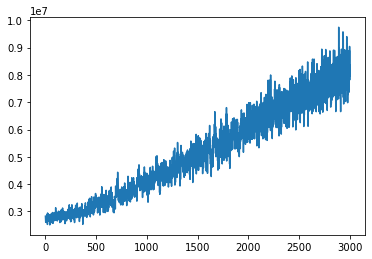

In [96]:
plt.plot(best_loss_history);

# Какой же точности мы добились на тестовых данных?

In [95]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.112000
